In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
from pathlib import Path
from Levenshtein import distance

path = Path('data')
train_labels = pd.read_csv(path / 'train_labels_tokenized.csv')
train_labels

,image_id,InChI,InChI_1,InChI_text
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,C13H20OS,C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 -...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,C21H30O4,C 21 H 30 O 4 /c 1 - 12 ( 22 ) 25 - 14 - 6 - 8...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,C24H23N5O4,C 24 H 23 N 5 O 4 /c 1 - 14 - 13 - 15 ( 7 - 8 ...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,C17H24N2O4S,C 17 H 24 N 2 O 4 S /c 1 - 12 ( 20 ) 18 - 13 (...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,C10H19N3O2S,C 10 H 19 N 3 O 2 S /c 1 - 15 - 10 ( 14 ) 12 -...
...,...,...,...,...
2424181,ffffe824f539,InChI=1S/C10H12F2N2O3/c1-17-7-2-5(3-8(15)16)9(...,C10H12F2N2O3,C 10 H 12 F 2 N 2 O 3 /c 1 - 17 - 7 - 2 - 5 ( ...
2424182,ffffea1ebdfa,InChI=1S/C19H20F2N4O3S/c1-10(8-20)28-14-7-12(2...,C19H20F2N4O3S,C 19 H 20 F 2 N 4 O 3 S /c 1 - 10 ( 8 - 20 ) 2...
2424183,ffffee2b4534,InChI=1S/C22H26Cl2N2O4S/c1-16-6-2-3-10-21(16)3...,C22H26Cl2N2O4S,C 22 H 26 Cl 2 N 2 O 4 S /c 1 - 16 - 6 - 2 - 3...
2424184,fffff0b6eea6,InChI=1S/C17H26N2O6S/c1-23-16-12-14(4-5-15(16)...,C17H26N2O6S,C 17 H 26 N 2 O 6 S /c 1 - 23 - 16 - 12 - 14 (...


In [2]:
from src.dm import Dataset
from src.utils import get_image_path
import albumentations as A 
import torch


sample = train_labels.sample(100)
images = sample.image_id.map(get_image_path)

ds = Dataset(images.values, train=False, trans=A.Compose([A.Resize(128,128)]))
dl = torch.utils.data.DataLoader(ds, batch_size=100, num_workers=0, pin_memory=True, shuffle=False)

len(ds)

100

In [15]:
import glob 

models = glob.glob('*.ckpt')
models

['transformer-val_loss=0.3468.ckpt',
 'transformer-val_loss=0.3370.ckpt',
 'transformer-val_loss=0.4237.ckpt']

In [16]:
from src.models import Transformer
from src.vocab import VOCAB

model_path = 'transformer-val_loss=0.3468.ckpt'
model = Transformer.load_from_checkpoint(model_path, len_vocab=len(VOCAB))
model.hparams

"batch_size":         256
"dropout":            0.0
"embed_dim":          256
"gpus":               1
"gradient_clip_val":  1.0
"img_size":           128
"len_vocab":          193
"load_from":          False
"log":                True
"lr":                 0.001
"max_epochs":         30
"max_len":            277
"nhead":              4
"num_decoder_layers": 6
"num_encoder_layers": 6
"num_workers":        24
"optimizer":          Adam
"patch_size":         16
"pin_memory":         True
"precision":          16
"shuffle_train":      True
"subset":             0.01
"train_batches":      1.0
"train_trans":        {'Resize': {'width': 128, 'height': 128}}
"val_batches":        1.0
"val_trans":          {'Resize': {'width': 128, 'height': 128}}
"val_with_train":     False

In [17]:
from tqdm import tqdm

preds = []
model.cuda()
for batch in tqdm(dl):
    outputs = model.predict(batch)
    preds += outputs
    
len(preds)

100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


100

In [18]:
imgs = next(iter(dl))

imgs.shape

torch.Size([100, 1, 128, 128])

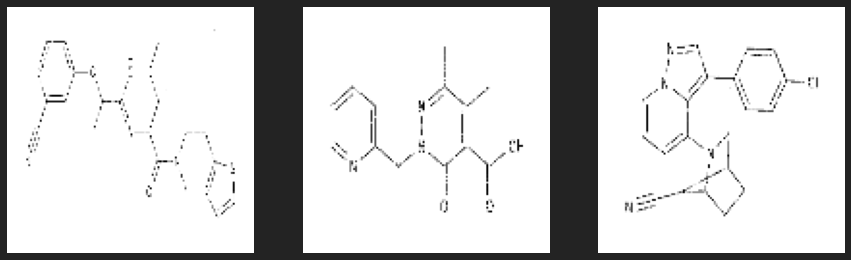

In [19]:
fig = plt.figure(figsize=(15,5))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    ax.imshow(imgs[i].squeeze(0), cmap="gray")
    ax.axis('off')
plt.show()

In [30]:
model.eval()
B = 3
with torch.no_grad():
    # start of sentence
    eos = torch.tensor([1], dtype=torch.long, device=model.device).expand(B, 1)
    trg_input = eos
    for i in range(10):
        preds = model(imgs[:3].to(model.device), trg_input)
        preds = torch.argmax(preds, axis=2)
        trg_input = torch.cat([eos, preds], 1)
        print(preds)

tensor([[181],
        [181],
        [181]], device='cuda:0')
tensor([[181,  61],
        [181,  61],
        [181,  61]], device='cuda:0')
tensor([[181,  61, 185],
        [181,  61, 185],
        [181,  61, 185]], device='cuda:0')
tensor([[181,  61, 185,  93],
        [181,  61, 185,  93],
        [181,  61, 185,  93]], device='cuda:0')
tensor([[181,  61, 185,  93, 187],
        [181,  61, 185,  93, 187],
        [181,  61, 185,  93, 187]], device='cuda:0')
tensor([[181,  61, 185,  93, 187, 102],
        [181,  61, 185,  93, 187, 102],
        [181,  61, 185,  93, 187, 102]], device='cuda:0')
tensor([[181,  61, 185,  93, 187, 102, 188],
        [181,  61, 185,  93, 187, 102, 188],
        [181,  61, 185,  93, 187, 102, 188]], device='cuda:0')
tensor([[181,  61, 185,  93, 187, 102, 188,  91],
        [181,  61, 185,  93, 187, 102, 188,  91],
        [181,  61, 185,  93, 187, 102, 188,  91]], device='cuda:0')
tensor([[181,  61, 185,  93, 187, 102, 188,  91,   9],
        [181,  61, 18

In [18]:
preds[:3]

[tensor([181,  61, 185,  89, 187,  91, 188,  91,   9,  16,   7,  17,   7, 113,
           7, 124,   7,  28,   3, 157,   7,  72,   4,  61,   3,  17,   4,  83,
           7, 146,   7, 135,   7,  39,   3, 168,   7,  83,   4,  50,   3,  88,
           4,  89,   7,  91,  10, 102,   7, 124,   6, 157,   6,  39,   6,  88,
         185,   6, 135,   7, 146,   6, 168, 185,  91,   6,  16,   7,  91, 185,
         102,   2], device='cuda:0'),
 tensor([181,  61, 185,  89, 187,  91, 188,  91,   9,  16,   7,  17,   7, 113,
           7, 124,   7,  28,   3, 157,   7,  72,   4,  61,   3,  17,   4,  83,
           7, 146,   7, 135,   7,  39,   3, 168,   7,  83,   4,  50,   3,  88,
           4,  89,   7,  91,  10, 102,   7, 124,   6, 157,   6,  39,   6,  88,
         185,   6, 135,   7, 146,   6, 168, 185,  91,   6,  16,   7,  91, 185,
         102,   2], device='cuda:0'),
 tensor([181,  61, 185,  89, 187,  91, 188,  91,   9,  16,   7,  17,   7, 113,
           7, 124,   7,  28,   3, 157,   7,  72,   4,  

In [10]:
from src.utils import parse_config_file
from src.dm import DataModule

config_file = 'debug.yml'
config = parse_config_file(config_file)

dm = DataModule(**config)
dm.setup()

Training samples:  2181
Validation samples:  243


In [13]:
preds_decoded = [dm.decode(pred) for pred in preds]
preds_decoded[:5]

['C14H18N2O2/c1-10-4-5-11(8-15)14(10)16-7-6-12(9-16)13(17)18-2/h3-5,8,12,17H,6-7,9H2,1-2H3',
 'C14H18N2O2/c1-10-4-5-11(8-15)14(10)16-7-6-12(9-16)13(17)18-2/h3-5,8,12,17H,6-7,9H2,1-2H3',
 'C14H18N2O2/c1-10-4-5-11(8-15)14(10)16-7-6-12(9-16)13(17)18-2/h3-5,8,12,17H,6-7,9H2,1-2H3',
 'C14H18N2O2/c1-10-4-5-11(8-15)14(10)16-7-6-12(9-16)13(17)18-2/h3-5,8,12,17H,6-7,9H2,1-2H3',
 'C14H18N2O2/c1-10-4-5-11(8-15)14(10)16-7-6-12(9-16)13(17)18-2/h3-5,8,12,17H,6-7,9H2,1-2H3']

In [16]:
preds_inchis = ['InChI=1S/' + pred for pred in preds_decoded]
preds_inchis[:3]

['InChI=1S/C14H18N2O2/c1-10-4-5-11(8-15)14(10)16-7-6-12(9-16)13(17)18-2/h3-5,8,12,17H,6-7,9H2,1-2H3',
 'InChI=1S/C14H18N2O2/c1-10-4-5-11(8-15)14(10)16-7-6-12(9-16)13(17)18-2/h3-5,8,12,17H,6-7,9H2,1-2H3',
 'InChI=1S/C14H18N2O2/c1-10-4-5-11(8-15)14(10)16-7-6-12(9-16)13(17)18-2/h3-5,8,12,17H,6-7,9H2,1-2H3']

In [17]:
import numpy as np 

metric = []
for pred, inchi in zip(preds_inchis, sample.InChI.values):
    metric.append(distance(pred, inchi))
    
np.mean(metric)

72.19

In [ ]:
import glob 
from pathlib import Path 

test_images = glob.glob('data/test/*/*/*/*.png')
#test_images = glob.glob('data/bms100/test/*.png')

len(test_images)

In [ ]:
from src.dm import Dataset
import albumentations as A 

#limit = 100000
#test_images = test_images[:limit]

ds = Dataset(test_images, train=False, trans=A.Compose([A.Resize(128,128)]))
#ds = Dataset(test_images, train=False, trans=None)
len(ds)

In [ ]:
import torch

dl = torch.utils.data.DataLoader(ds, batch_size=100, num_workers=0, pin_memory=True, shuffle=False)

imgs = next(iter(dl))
imgs.shape

In [ ]:
from tqdm import tqdm

preds = []
model.cuda()
for batch in tqdm(dl):
    outputs = model.predict(batch.cuda())
    preds += outputs
len(preds)

In [ ]:
import pandas as pd

submission = pd.DataFrame({
    'image_id': [image_id.split('/')[-1][:-4] for image_id in test_images],
    #'image_id': [image_id.split('/')[-1][:-4] for image_id in test_images[:32]],
    'InChI': ['InChI=1S/'+pred for pred in preds]
})

submission

In [ ]:
submission.sample(10)

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
#!kaggle competitions list
#!kaggle competitions submit bms-molecular-translation -f submission.csv -m "My submission message"